# Introduction

In this example, we will demonstrate linear methods for classification. The dataset we are using is from Zhuo et al. J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673, but we have pre-filtered it in the following manner:
1. Only binary compounds, i.e., AxBy
2. Each element pair only has one band gap. The AxBy with the lowest formation energy per atom for each pair of A and B is retained.

In [1]:
import pandas as pd
from pymatgen import Element, Composition
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
rcparams = {'legend.fontsize': 20,
            'figure.figsize': (12, 8),
            'axes.labelsize': 24,
            'axes.titlesize': 28,
            'xtick.labelsize':20,
            'ytick.labelsize': 20}
sns.set(rc=rcparams)
mpl.rcParams.update(rcparams)

%matplotlib inline

# This sets the inline figures to high resolution for Retina display...
%config InlineBackend.figure_format ='retina'

In [2]:
binaries = pd.read_csv('binary_band_gap.csv')
# The head() method in DataFrame is useful to get a look at the 
# first few entries so that we know what the dataset looks like.
binaries.head()

,Formula,Eg (eV)
0,AgAu3,0.00
1,BaAg2,0.00
2,AgBr,2.52
3,CdAg,0.00
4,AgCl,5.13


We will use pymatgen's Composition class to create a column with an actual Compositon object.

In [3]:
binaries['composition'] = [Composition(c) for c in binaries['Formula']]

Let's create our features, which are the mean and absolute difference in electronegativities between the elements. We will also define our classes, which are metals (Eg = 0) and insulators (Eg > 0).

In [4]:
def classify(eg):
    # We specific metals to be band gap less than 1e-5. 
    # Note that we do not use eg==0.0 since float representation
    # in python is not precise
    if eg < 1e-5:   
        return 0
    else:
        return 1

electronegs = [[el.X for el in c] for c in binaries['composition']]
binaries['mean_X'] = [np.mean(e) for e in electronegs]
binaries['diff_X'] = [max(e) - min(e) for e in electronegs]
binaries['class'] = [classify(eg) for eg in binaries['Eg (eV)']]
# Here, we will print out a few lines to see what our dataset looks like now.
binaries.head()

,Formula,Eg (eV),composition,mean_X,diff_X,class
0,AgAu3,0.00,"(Ag, Au)",2.235,0.61,0
1,BaAg2,0.00,"(Ba, Ag)",1.410,1.04,0
2,AgBr,2.52,"(Ag, Br)",2.445,1.03,1
3,CdAg,0.00,"(Cd, Ag)",1.810,0.24,0
4,AgCl,5.13,"(Ag, Cl)",2.545,1.23,1


Let's plot our features and dataset.

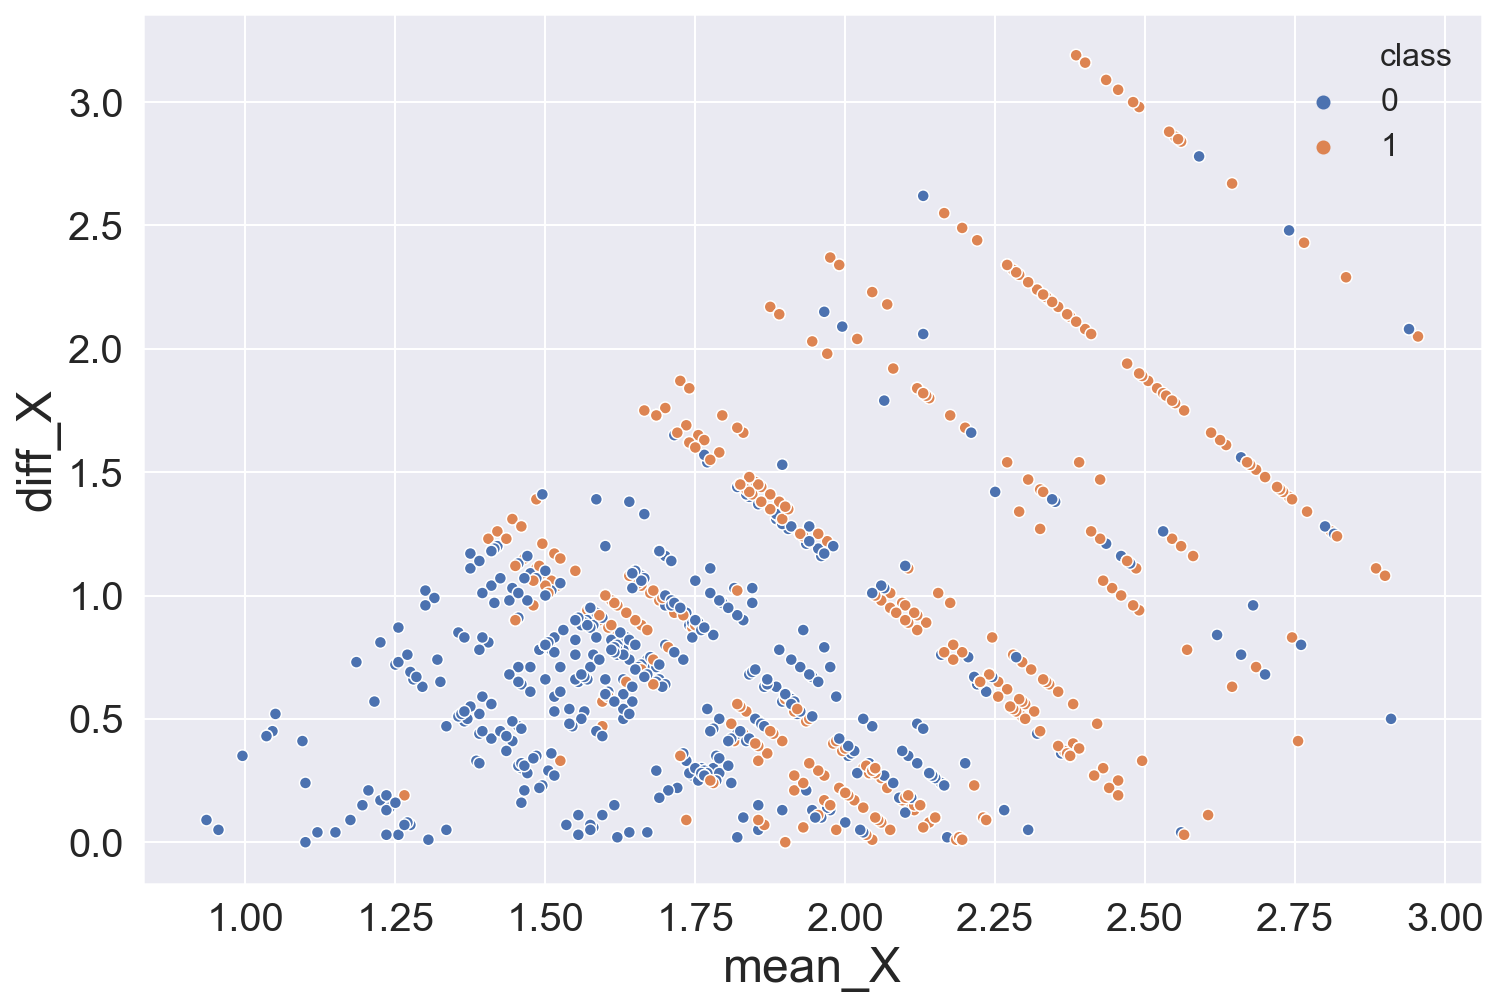

In [5]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='mean_X', y='diff_X', hue='class', data=binaries)
plt.legend(frameon=False, fontsize=16);

# Data splits to train and test

### Why data splits? 

We cannot just train the model on (X, y) and then evaluate on (X, y), since those models will be useless. We can always artificially increase the model complexity so that the model fits (X, y) perfectly. However, that model will most likely fail if we are interested in predicting y' from new X'. Therefore, the true model performance should be evaluated on data that are not seen in the training process. 


For this simple system, we just split the data into train and test, where we train the model on the train data set and evaluate the model on the test data set. 

### Where is the validation data? 

Some models will have configurational parameters that are not learnt in the training process but rather are set before the model training. For example, `fit_intercept` in the `sklearn.linear_model.LinearRegression` is a hyperparameter. You can have different models by setting `fit_intercept=True` or `fit_intercept=False`. How do we make the choice? 

Here is what we can do. We split the data into train, validation and test. We also initialize two models, one with `fit_intercept=True` and the other with `fit_intercept=False`. Then we train the two models on the train data set. The model performances are evaluated on the validation set (not seen during training, so the performance evaluation is legit). Then we choose the model based on their performance on the validation set. The final chosen model is evaluated on the test set. This is typically how the validation set is used for selecting the hyperparameters.

Some may ask, why not just train the two models and then use their test performance for selecting the models? In that case, you have information leakage. The test data is used for your model decision making and the performance in that "test" data cannot represent the real world model performance on unseen data. 


Here for the sake of simplicity, we fix all the hyperparameters (no need to choose hyperparameters) and split the data into train and test.


In [6]:
from sklearn.model_selection import train_test_split

X = binaries[["mean_X", "diff_X"]]
y = binaries["class"]

# Test data is 10%
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)

Note that the split is (pseudo-) random. Here I am passing a random seed of `42` to the function so that it is reproducible every time you run the code. 

For more reliable models, you will need to do multiple random splits, train the models on each split and average the results, or preferably do a cross-validation.

# Linear Discriminant Analysis

First let us implement a useful plotting function for visualizing the results of the classification.

In [13]:
from scipy import linalg

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# #############################################################################
# Colormap
cmap = mpl.colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Plot functions
def plot_data(da, X, y, plot_ellipses=True):
    sns.scatterplot(X["mean_X"], X["diff_X"], hue=y)

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    #  xx, yy creates points covering the entire 2D area
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    # Predict the probability at any point
    Z = da.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 0].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=mpl.colors.Normalize(0., 1.), zorder=0)
    # Contour plots with only one level, 0.5
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')
    ax = plt.gca()
    
    if plot_ellipses:
        # means
        for i, mean in enumerate(da.means_):        
            plt.plot(mean[0], mean[1],
                     '*', color='yellow', markersize=15, markeredgecolor='grey')
            # This plots an Ellipse showing the location of the mean and covariance.
            if isinstance(da, LinearDiscriminantAnalysis):
                cov = da.covariance_
            else:
                cov = da.covariance_[i]
            v, w = linalg.eigh(cov)
            u = w[0] / linalg.norm(w[0])
            angle = np.arctan(u[1] / u[0])
            angle = 180 * angle / np.pi  # convert to degrees
            # filled Gaussian at 2 standard deviation
            ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                                      180 + angle, facecolor="grey",
                                      edgecolor='black', linewidth=2)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.2)
            ax.add_artist(ell)

    return plt

In [15]:
plt.annotate?

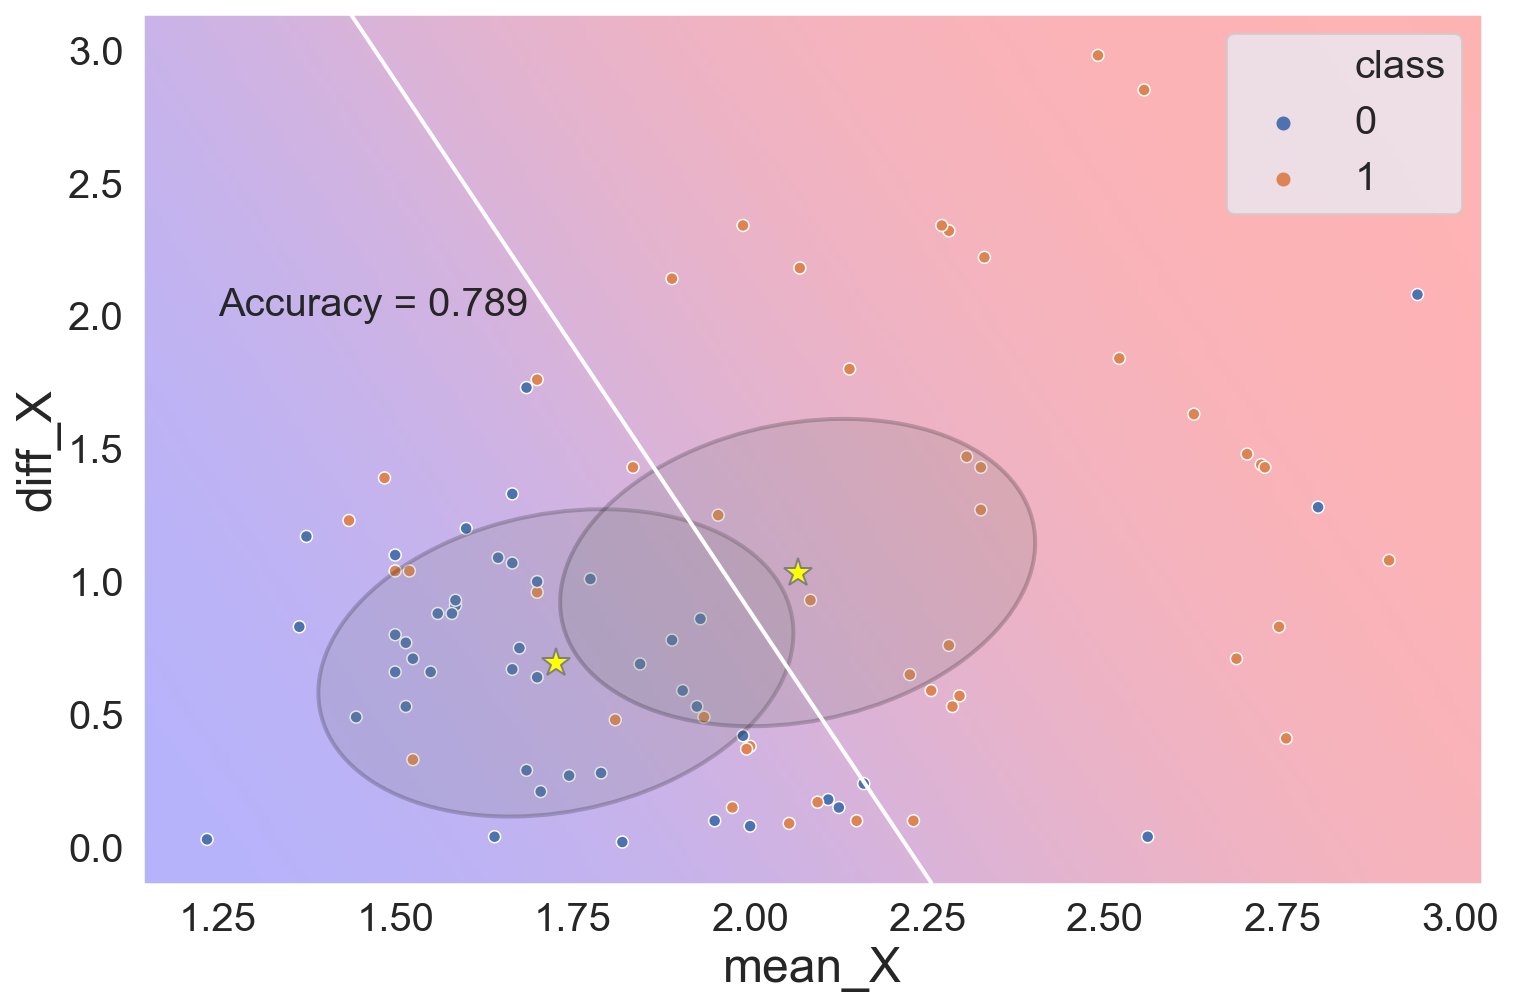

In [17]:
plt.figure(figsize=(12, 8))
# The hyperparameters such as `store_covariance` is set to a fixed value
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

model = lda.fit(train_X, train_y)

y_pred = model.predict(test_X)
splot = plot_data(lda, test_X, test_y)

# Compute the test accuracy
splot.annotate("Accuracy = %.3f" % model.score(test_X, test_y), (1.25, 2), fontsize=20);

For classification problems, `model.score` returns the accuracy. 

# Quadratic Discrimnant Analysis

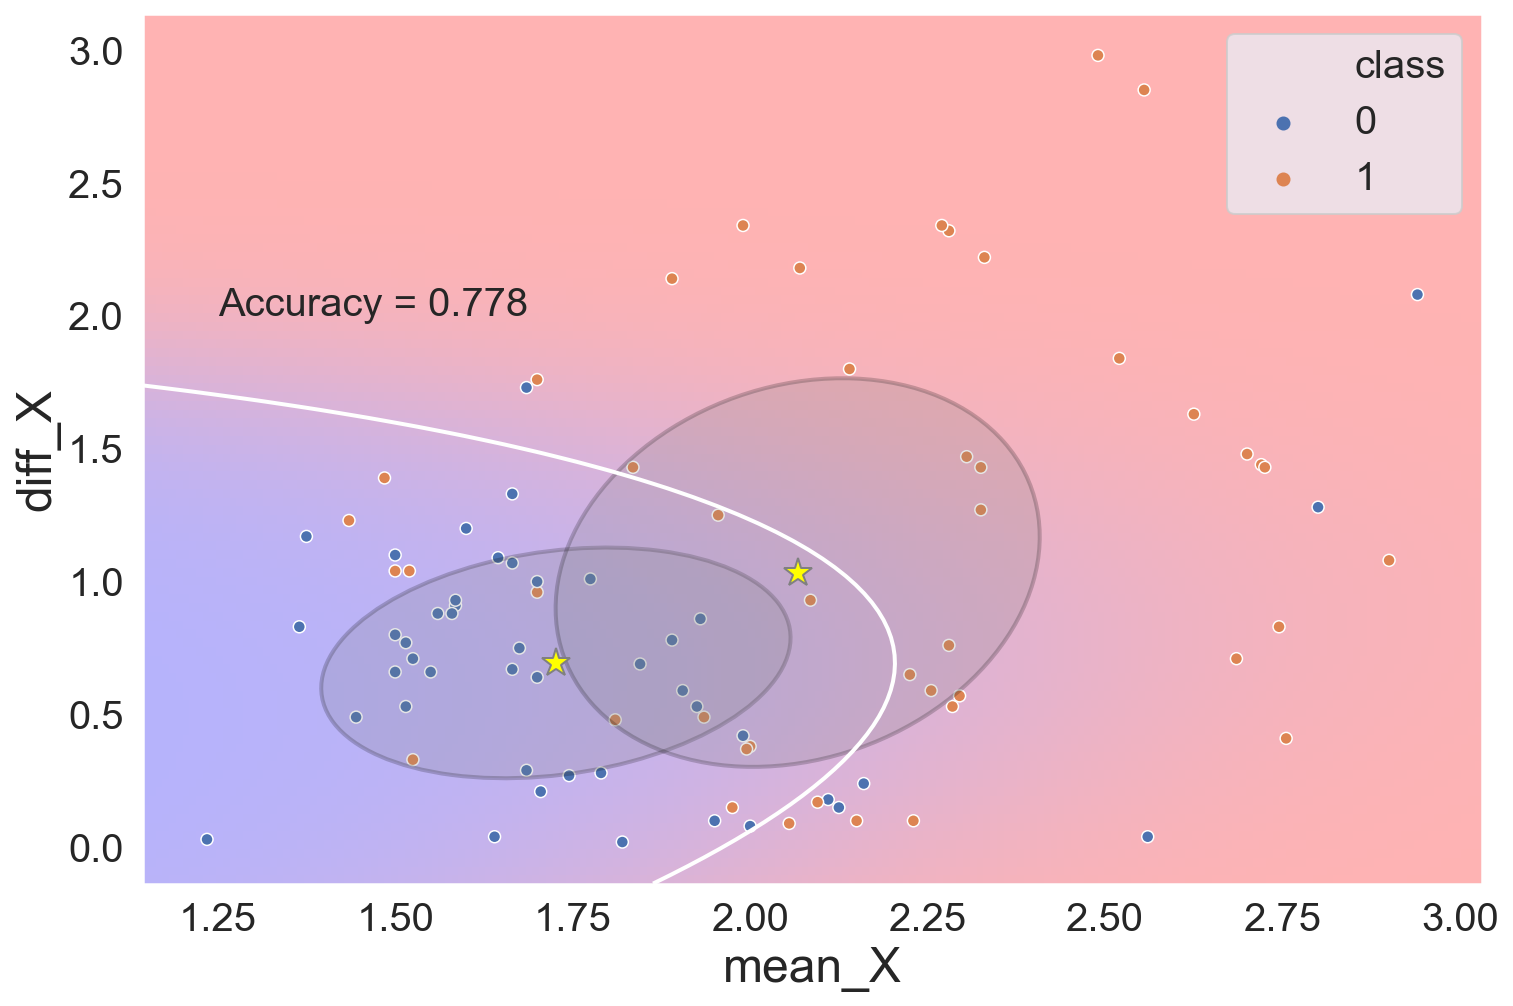

In [18]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
model = qda.fit(train_X, train_y)
y_pred = model.predict(test_X)

plt.figure(figsize=(12, 8))
plot = plot_data(qda, test_X, test_y)
plot.annotate("Accuracy = %.3f" % model.score(test_X, test_y), (1.25, 2), fontsize=20);

# Logistic Regression

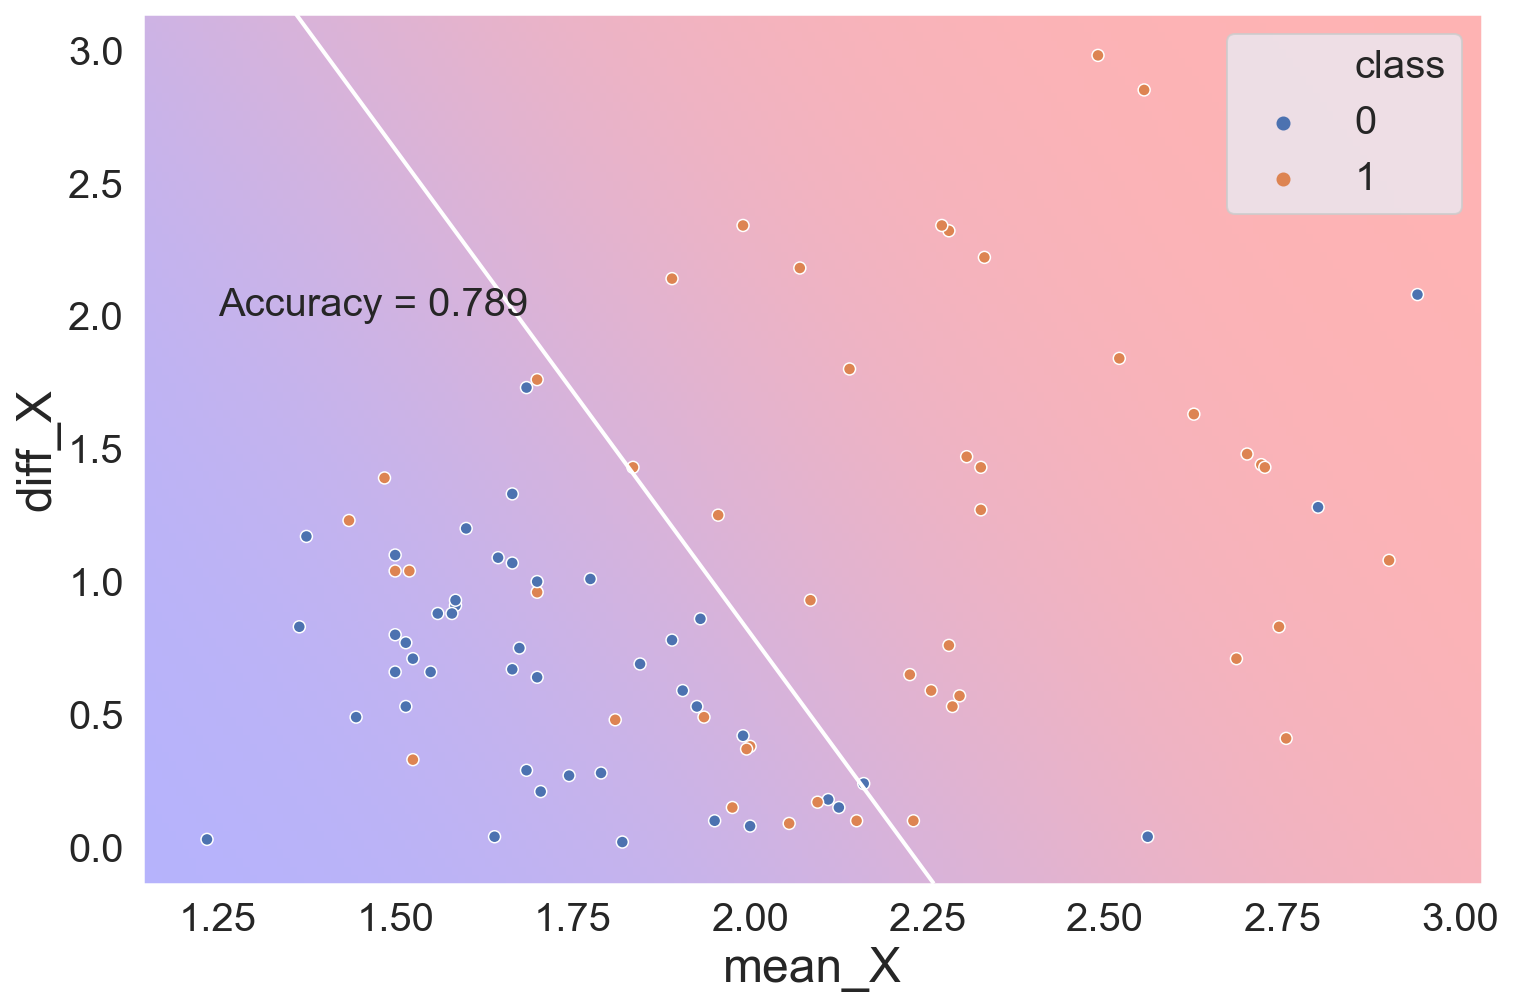

In [20]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='none', solver='lbfgs')
model = clf.fit(train_X, train_y)
y_pred = model.predict(test_X)

plt.figure(figsize=(12, 8))
plot = plot_data(clf, test_X, test_y, plot_ellipses=False)
plot.annotate("Accuracy = %.3f" % model.score(test_X, test_y), (1.25, 2), fontsize=20);